# HRC Price Prediction for Japan

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [39]:
# Read csv
df_CN = pd.read_csv('../data/processed/after_fillna.csv')
df_CN = df_CN[['Date', 'Month', 'HRC (FOB, $/t)']]

In [40]:
# Read csv
df_JP = pd.read_excel('../data/raw/Japan HRC FOB.xlsx')
df_JP.rename(columns={'Month': 'Month_JP'}, inplace=True)

In [41]:
hrc_price_CN_JP = pd.concat([df_CN, df_JP], axis=1, ignore_index=False)
hrc_price_CN_JP

,Date,Month,"HRC (FOB, $/t)",Month_JP,Japan HRC FOB ($/t)
0,2006-01-01,Jan-06,388.0,2006-01-01,480
1,2006-02-01,Feb-06,388.0,2006-02-01,480
2,2006-03-01,Mar-06,449.0,2006-03-01,490
3,2006-04-01,Apr-06,478.0,2006-04-01,460
4,2006-05-01,May-06,505.0,2006-05-01,490
...,...,...,...,...,...
225,2024-10-01,Oct-24,497.0,2024-10-01,540
226,2024-11-01,Nov-24,485.0,2024-11-01,550
227,2024-12-01,Dec-24,473.0,2024-12-01,520
228,2025-01-01,Jan-25,461.0,2025-01-01,520


In [42]:
hrc_price_CN_JP.columns

Index(['Date', 'Month', 'HRC (FOB, $/t)', 'Month_JP', 'Japan HRC FOB ($/t)'], dtype='object')

In [43]:
hrc_price_CN_JP.rename(columns={'HRC (FOB, $/t)': 'China HRC (FOB, $/t)',
                               'Japan HRC FOB ($/t)': 'Japan HRC (FOB, $/t)'}, inplace=True)
hrc_price_CN_JP.drop(['Month_JP'], axis=1, inplace=True)
hrc_price_CN_JP

,Date,Month,"China HRC (FOB, $/t)","Japan HRC (FOB, $/t)"
0,2006-01-01,Jan-06,388.0,480
1,2006-02-01,Feb-06,388.0,480
2,2006-03-01,Mar-06,449.0,490
3,2006-04-01,Apr-06,478.0,460
4,2006-05-01,May-06,505.0,490
...,...,...,...,...
225,2024-10-01,Oct-24,497.0,540
226,2024-11-01,Nov-24,485.0,550
227,2024-12-01,Dec-24,473.0,520
228,2025-01-01,Jan-25,461.0,520


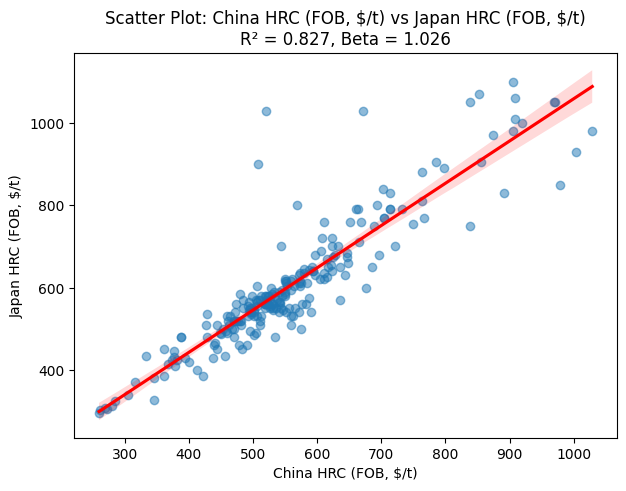

In [44]:
from scipy.stats import linregress

x_col = 'China HRC (FOB, $/t)'
y_col = 'Japan HRC (FOB, $/t)'

# Drop NaN values for the current variable
temp_df = hrc_price_CN_JP[[x_col, y_col]].dropna()

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(temp_df[x_col], temp_df[y_col])
r_squared = r_value**2  # R² value

# Create plot
plt.figure(figsize=(7, 5))
sns.regplot(x=temp_df[x_col], y=temp_df[y_col], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})

# Labels and title
plt.xlabel(x_col)
plt.ylabel(y_col)
x_col_name = x_col.replace("$", r"\$")
y_col_name = y_col.replace("$", r"\$")
plt.title(f"Scatter Plot: {x_col_name} vs {y_col_name}\nR² = {r_squared:.3f}, Beta = {slope:.3f}")

# Show plot
plt.show()